In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import h5py
import os.path
import random
import itertools
import time
import pickle
import json
from itertools import izip_longest
import matplotlib as mpl
import matplotlib.pyplot as plt
from pygaarst import hyperionutils as hyp
from pygaarst import irutils as ir
from pygaarst import raster
import random
import pandas as pd
import seaborn as sns
import configs

In [3]:
sns.set_context('paper', font_scale=2.5)
sns.set_style('whitegrid')
font = {'family' : 'Corbel',
        'weight' : 'bold',
        'size'   : 24}
mpl.rc('font', **font)

Generate HFDI, CO2 CIBR and K-emission related plots

In [2]:
basedir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/HyspIRI_Prep_2014/"
outdir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/HyspIRI_Prep_2014/visual/tmp/"

In [5]:
configs.FIREPARAM

{'boundary': {'colbarpos': [0.125, 0.2, 0.725, 0.025],
  'figdim': (15, 19),
  'filedir': '2004Boundary',
  'firename': 'boundary',
  'fireyear': 2004,
  'infix': '_CLIP',
  'sceneid': 'EO1H0690142004201110PX'},
 'crazy': {'colbarpos': [0.125, 0.2, 0.725, 0.025],
  'figdim': (15, 19),
  'filedir': '2004Crazy',
  'firename': 'crazy',
  'fireyear': 2004,
  'infix': '_CLIP',
  'sceneid': 'EO1H0680132004192110KY'},
 'woodriver': {'colbarpos': [0.125, 0.125, 0.74, 0.02],
  'figdim': (15, 25),
  'filedir': '2009WoodRiver',
  'firename': 'woodriver',
  'fireyear': 2009,
  'infix': '_CLIP',
  'sceneid': 'EO1H0690142009214110KF'}}

## Preliminaries

#### Step 1 : Fix a random seed

In [14]:
random.seed(6626)

#### Step 2: Generate a sample of fire and bg pixels

In [15]:
## how many samples to generate for each fire in each class
N = {
    'crazy': 100,
    'boundary': 100,
    'woodriver': 50
}

In [16]:
samplepix = []
for firename in configs.FIREPARAM:
    indir = configs.FIREPARAM[firename]['filedir']
    infilename = os.path.join(basedir, indir, "{}_random_forest_extraction.tif".format(firename))
    classification = raster.GeoTIFF(infilename)
    fireclass = np.ma.masked_not_equal(classification.data, 0)
    backgroundclass = np.ma.masked_outside(classification.data, 1, 2)
    fireindices = zip(*np.where(~fireclass.mask))
    backgroundindices = zip(*np.where(~backgroundclass.mask))
    firesample = random.sample(fireindices, N[firename])
    backgroundsample = random.sample(backgroundindices, N[firename])
    samplepix.extend([{'firename': firename, 'pixclass': 'fire', 'ii': ii, 'jj': jj} 
                      for (ii, jj) in firesample])
    samplepix.extend([{'firename': firename, 'pixclass': 'background', 'ii': ii, 'jj': jj} 
                      for (ii, jj) in backgroundsample])

In [17]:
sampleDF = pd.DataFrame.from_records(samplepix)
sampleDF.sort_values('ii').head()

,firename,ii,jj,pixclass
452,crazy,0,90,background
402,crazy,1,128,background
456,crazy,4,99,background
463,crazy,5,103,background
449,crazy,5,170,background


In [18]:
sampleDF.to_csv(
    os.path.join(outdir, "fire_bg_allfires_sample_{}.dat".format(len(samplepix))), sep='\t')

#### Step 3: Load sample from file 

In [19]:
sampleDF = pd.DataFrame.from_csv(
    os.path.join(basedir, 'Hyperion', "fire_bg_allfires_sample_{}.dat".format(2*sum(N.values()))), sep='\t'
)

In [20]:
sampleDF.sort_values('ii').head()

,firename,ii,jj,pixclass
452,crazy,0,90,background
402,crazy,1,128,background
456,crazy,4,99,background
463,crazy,5,103,background
449,crazy,5,170,background


#### Step 4: Add relevant radiance

In [126]:
bandnums = [42, 43, 183, 185, 188, 190, 191, 192, 193, 194, 195, 196, 216, 217, 218]
bandnames = ['band{}'.format(n) for n in bandnums]

In [127]:
hypsc = {}
for fnm in ['crazy', 'boundary', 'woodriver']:
    hypsc[fnm] = raster.Hyperionscene(os.path.join(basedir, 
        configs.FIREPARAM[fnm]['filedir'], configs.FIREPARAM[fnm]['sceneid']))
    hypsc[fnm].infix = '_CLIP'

INFO:root:The value 2004 192 21:07:57 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 192 21:09:12 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 201 21:02:11 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 201 21:03:21 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2009 214 20:40:37 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2009 214 20:44:55 couldn't be parsed as int, float, date, time, datetime. Returning it as string.


In [128]:
def getabandradiance_helper(row, bandname):
    return hypsc[row['firename']].__getattr__(bandname).radiance[row['ii'], row['jj']]

In [24]:
def bandradiancefunc(bandname):
    def getabandradiance(row):
        return getabandradiance_helper(row, bandname)
    return getabandradiance

In [25]:
for bandname in bandnames:
    sampleDF['rad_{}'.format(bandname)] = sampleDF.apply(bandradiancefunc(bandname), axis=1)

In [46]:
sampleDF

,firename,ii,jj,pixclass,rad_band42,rad_band43,rad_band183,rad_band185,rad_band188,rad_band190,...,hfdi_193_218,hfdi_194_216,hfdi_194_217,hfdi_194_218,hfdi_195_216,hfdi_195_217,hfdi_195_218,hfdi_196_216,hfdi_196_217,hfdi_196_218
0,boundary,148,225,fire,34.700001,35.025002,6.250000,1.7125,8.100000,5.700000,...,-0.035800,-0.016820,0.002999,-0.046420,-0.069465,-0.049716,-0.098885,-0.083393,-0.063681,-0.112738
1,boundary,201,88,fire,55.150002,54.674999,4.275000,1.8875,6.237500,4.350000,...,0.001862,-0.045078,-0.021583,-0.027125,-0.015180,0.008341,0.002796,-0.043318,-0.019820,-0.025362
2,boundary,193,187,fire,44.750000,45.174999,12.025000,4.5000,15.900000,12.200000,...,0.045519,0.035025,0.051300,0.042553,-0.008898,0.007407,-0.001359,-0.019966,-0.003663,-0.012429
3,boundary,137,252,fire,42.224998,43.224998,3.812500,1.0625,4.987500,3.737500,...,-0.021226,-0.058140,-0.006637,-0.045977,-0.060325,-0.008830,-0.048165,-0.073227,-0.021786,-0.061086
4,boundary,165,211,fire,39.950001,40.400002,3.650000,1.3250,4.950000,3.200000,...,-0.037241,-0.022398,-0.030544,-0.052917,-0.051151,-0.059278,-0.081579,-0.058376,-0.066496,-0.088773
5,boundary,219,95,fire,52.950001,52.299999,1.962500,0.3625,2.687500,1.912500,...,-0.269939,-0.204748,-0.211940,-0.260870,-0.240793,-0.247863,-0.295858,-0.220930,-0.228070,-0.276596
6,boundary,183,105,fire,40.724998,40.250000,3.787500,1.3750,5.550000,3.862500,...,-0.074661,-0.069155,-0.059848,-0.087054,-0.034169,-0.024831,-0.052144,-0.043968,-0.034637,-0.061927
7,boundary,188,184,fire,46.549999,46.625000,4.212500,1.5000,5.437500,3.900000,...,-0.008621,-0.062434,-0.036120,-0.043659,-0.048335,-0.021990,-0.029536,-0.057447,-0.031120,-0.038662
8,boundary,148,227,fire,39.700001,40.450001,3.237500,1.0000,4.237500,2.937500,...,-0.099688,-0.120715,-0.089855,-0.130827,-0.141194,-0.110482,-0.151248,-0.147399,-0.116737,-0.157434
9,boundary,204,164,fire,47.150002,47.450001,3.800000,1.4125,5.512500,3.687500,...,-0.070573,-0.053683,-0.055000,-0.094682,-0.104019,-0.105325,-0.144608,-0.100830,-0.102138,-0.141451


In [27]:
sampleDF.to_csv(
    os.path.join(outdir, "fire_bg_allfires_rad_sample_{}.dat".format(len(samplepix))), sep='\t')

#### Step 5: Add fire detection indices

In [54]:
sampleDF = pd.DataFrame.from_csv(
    os.path.join(basedir, 'Hyperion', "fire_bg_allfires_rad_sample_500.dat"), sep='\t'
)

In [56]:
def co2cibr(row):
    return row['rad_band185'] / (0.6667*row['rad_band183'] + 0.3333*row['rad_band188'])

In [57]:
sampleDF['co2cibr'] = sampleDF.apply(co2cibr, axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125015210>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12261da50>], dtype=object)

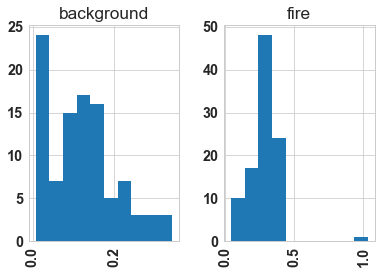

In [58]:
sampleDF[sampleDF['firename']=='boundary'].hist(by='pixclass', column='co2cibr')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125437cd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1255fd1d0>], dtype=object)

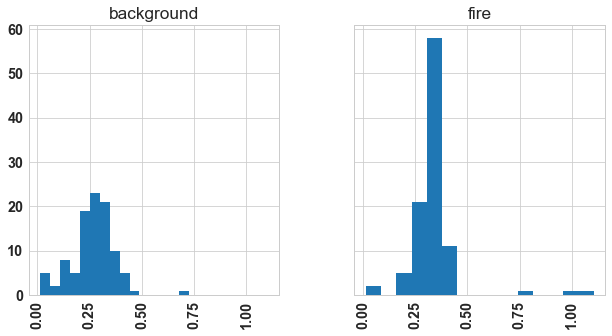

In [59]:
sampleDF[sampleDF['firename']=='crazy'].hist(
    by='pixclass', column='co2cibr',
    figsize=(10, 5), sharex=True, sharey=True, bins=15)

In [64]:
def kemiss(row):
    return row['rad_band42'] / row['rad_band43']
def kemiss_akbd(row):
    return row['rad_band42'] - row['rad_band43']
def hfdi(row, colname1, colname2):
    return (row[colname2] - row[colname1])/(row[colname2] + row[colname1])
def hfdi_func(colname1, colname2):
    def hfdi_forcols(row):
        return hfdi(row, colname1, colname2)
    return hfdi_forcols

In [65]:
sampleDF['kemiss'] = sampleDF.apply(kemiss, axis=1)
sampleDF['kemiss_akbd'] = sampleDF.apply(kemiss_akbd, axis=1)

In [66]:
for low, high in itertools.product([190, 191, 192, 193, 194, 195, 196], [216, 217, 218]):
    colnames = "rad_band{}".format(low), "rad_band{}".format(high)
    newcolname = 'hfdi_{}_{}'.format(low, high)
    sampleDF[newcolname] = sampleDF.apply(hfdi_func(*colnames), axis=1)

In [67]:
hfdicols = ["hfdi_{}_{}".format(low, high) for low, high in itertools.product([191, 192, 193, 194, 195, 196], [216, 217, 218])]

In [68]:
hfdicols

['hfdi_191_216',
 'hfdi_191_217',
 'hfdi_191_218',
 'hfdi_192_216',
 'hfdi_192_217',
 'hfdi_192_218',
 'hfdi_193_216',
 'hfdi_193_217',
 'hfdi_193_218',
 'hfdi_194_216',
 'hfdi_194_217',
 'hfdi_194_218',
 'hfdi_195_216',
 'hfdi_195_217',
 'hfdi_195_218',
 'hfdi_196_216',
 'hfdi_196_217',
 'hfdi_196_218']

In [69]:
sampleDF['hfdi_avg'] = sampleDF[hfdicols].mean(axis=1)

In [70]:
sampleDF.columns

Index([u'firename', u'ii', u'jj', u'pixclass', u'rad_band42', u'rad_band43',
       u'rad_band183', u'rad_band185', u'rad_band188', u'rad_band190',
       u'rad_band191', u'rad_band192', u'rad_band193', u'rad_band194',
       u'rad_band195', u'rad_band196', u'rad_band216', u'rad_band217',
       u'rad_band218', u'co2cibr', u'kemiss', u'kemiss_akbd', u'hfdi_190_216',
       u'hfdi_190_217', u'hfdi_190_218', u'hfdi_191_216', u'hfdi_191_217',
       u'hfdi_191_218', u'hfdi_192_216', u'hfdi_192_217', u'hfdi_192_218',
       u'hfdi_193_216', u'hfdi_193_217', u'hfdi_193_218', u'hfdi_194_216',
       u'hfdi_194_217', u'hfdi_194_218', u'hfdi_195_216', u'hfdi_195_217',
       u'hfdi_195_218', u'hfdi_196_216', u'hfdi_196_217', u'hfdi_196_218',
       u'hfdi_avg'],
      dtype='object')

In [71]:
sampleDF.to_csv(
    os.path.join(outdir, "fire_bg_allfires_with_indices_sample_{}.dat".format(len(samplepix))), sep='\t')

#### Step 6: Plots 

In [3]:
from scipy import stats
import brewer2mpl

In [4]:
sampleDF = pd.DataFrame.from_csv(
    os.path.join(basedir, 'Hyperion', "fire_bg_allfires_with_indices_sample_500.dat"), sep='\t'
)

In [5]:
sampleDF.columns

Index([u'firename', u'ii', u'jj', u'pixclass', u'rad_band42', u'rad_band43',
       u'rad_band183', u'rad_band185', u'rad_band188', u'rad_band190',
       u'rad_band191', u'rad_band192', u'rad_band193', u'rad_band194',
       u'rad_band195', u'rad_band196', u'rad_band216', u'rad_band217',
       u'rad_band218', u'co2cibr', u'kemiss', u'kemiss_akbd', u'hfdi_190_216',
       u'hfdi_190_217', u'hfdi_190_218', u'hfdi_191_216', u'hfdi_191_217',
       u'hfdi_191_218', u'hfdi_192_216', u'hfdi_192_217', u'hfdi_192_218',
       u'hfdi_193_216', u'hfdi_193_217', u'hfdi_193_218', u'hfdi_194_216',
       u'hfdi_194_217', u'hfdi_194_218', u'hfdi_195_216', u'hfdi_195_217',
       u'hfdi_195_218', u'hfdi_196_216', u'hfdi_196_217', u'hfdi_196_218',
       u'hfdi_avg'],
      dtype='object')

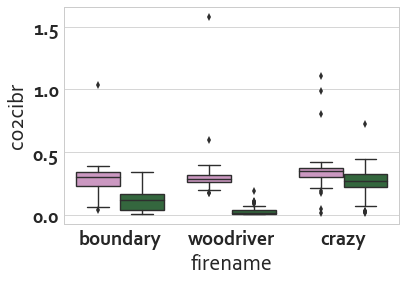

In [8]:
ax = sns.boxplot(
    x="firename", y="co2cibr", 
    hue="pixclass", data=sampleDF, 
    palette="cubehelix_r",
    )
ax.legend_.remove()
#ax.set_ylim([-.1, 1.6])

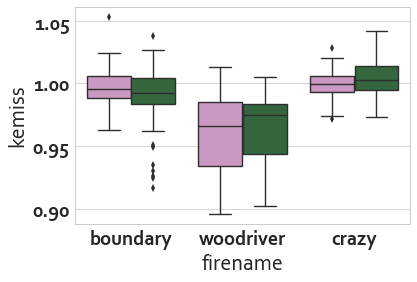

In [9]:
ax = sns.boxplot(x="firename", y="kemiss", hue="pixclass", data=sampleDF, palette="cubehelix_r")
ax.legend_.remove()

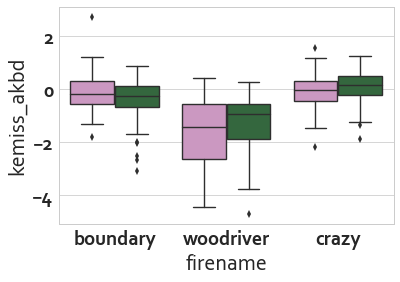

In [10]:
ax = sns.boxplot(x="firename", y="kemiss_akbd", hue="pixclass", data=sampleDF, palette="cubehelix_r")
ax.legend_.remove()

In [11]:
idx = 6
ii = idx // 3
jj = (idx - 3) % 3
ii, jj

(2, 0)

In [12]:
sns.set_context('paper', font_scale=1.8)
sns.set_style('whitegrid')


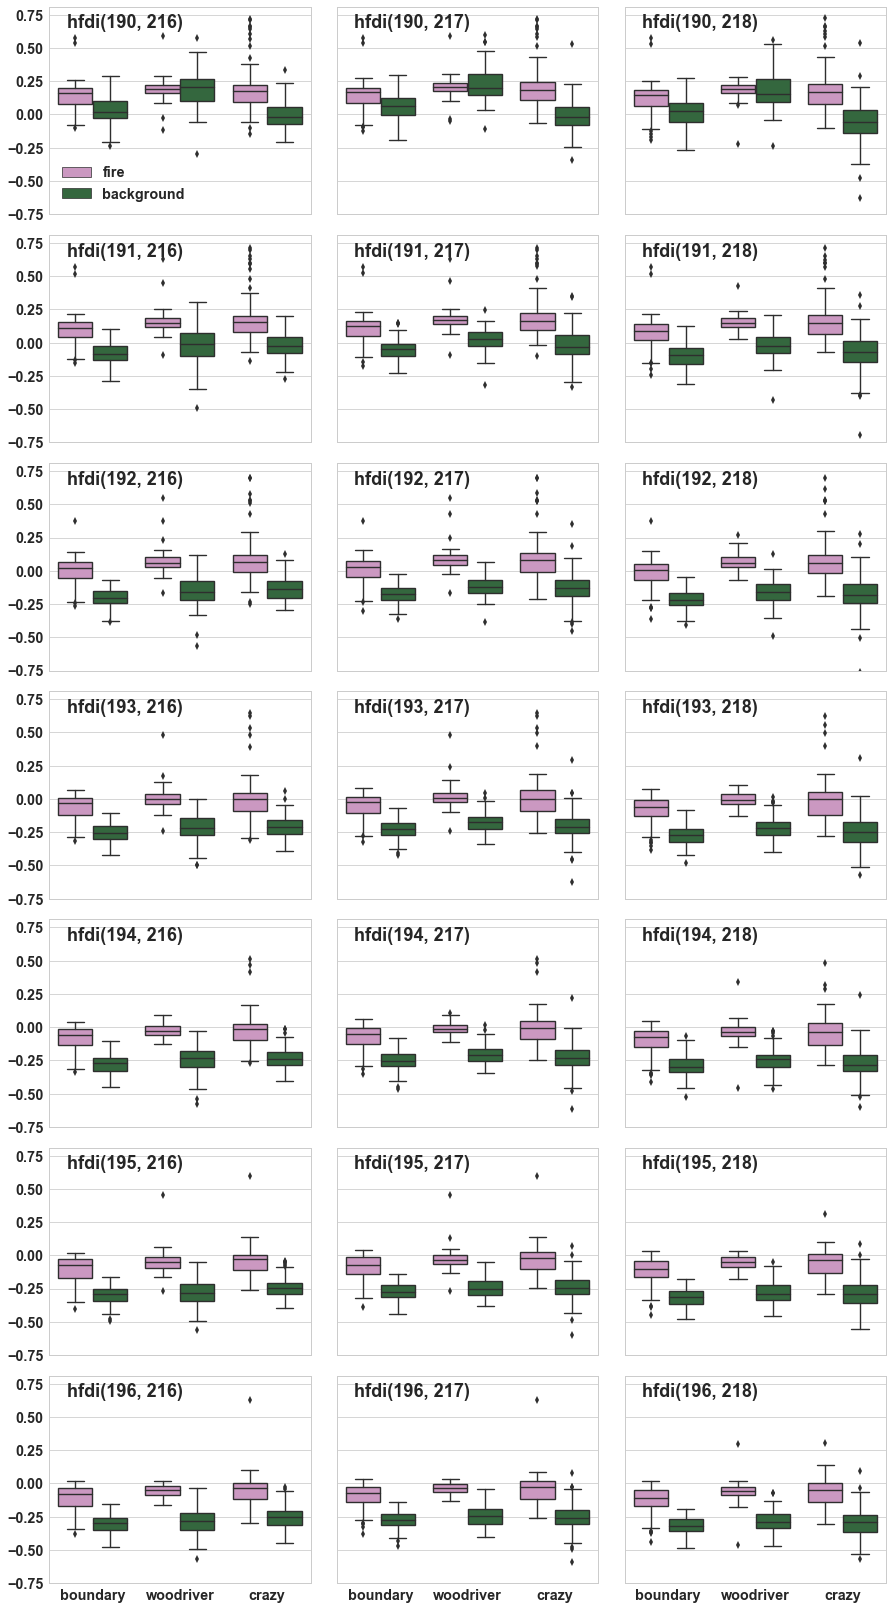

In [14]:
fig, axs = plt.subplots(7, 3, sharex=True, figsize=(15, 29))
for idx, (low, high) in enumerate(itertools.product([190, 191, 192, 193, 194, 195, 196], [216, 217, 218])):
    ii = idx // 3
    jj = (idx - 3) % 3
    sns.boxplot(x="firename", 
                y="hfdi_{}_{}".format(low, high), 
                hue="pixclass", data=sampleDF, palette="cubehelix_r",
                   ax=axs[ii][jj])
    axs[ii][jj].legend_.remove()
    axs[ii][jj].set_ylabel("")
    axs[ii][jj].set_xlabel("")
    if jj != 0:
        axs[ii][jj].set_yticklabels([])
    axs[ii][jj].set_ylim([-0.75, .81])
    axs[ii][jj].text(-.3, .65, 'hfdi({}, {})'.format(low, high), fontsize=18)
axs[0][0].legend(loc=3)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

In [6]:
mean_bg, std_bg = sampleDF[sampleDF.pixclass=='background'].mean(), sampleDF[sampleDF.pixclass=='background'].std()
mean_fire, std_fire = sampleDF[sampleDF.pixclass=='fire'].mean(), sampleDF[sampleDF.pixclass=='fire'].std()

In [7]:
BINS = np.arange(-1, 1, 0.025)
N = 100
bmap = brewer2mpl.get_map('Set1', 'qualitative', 7)
colors = bmap.mpl_colors
b1 = 194
b2 = 218

In [8]:
def plot_histfits(lowerbd, upperbd):
    bandlabel = 'hfdi_{}_{}'.format(lowerbd, upperbd)

    f, ax = plt.subplots(1, 1, figsize=(15, 12))
    ax.plot(
        np.linspace(-1, 1, N), 
        stats.norm.pdf(np.linspace(-1, 1, N), 
        loc=mean_bg[bandlabel], scale=std_bg[bandlabel]), label='background')
    ax.plot(
        np.linspace(-1, 1, N), 
        stats.norm.pdf(np.linspace(-1, 1, N), 
        mean_fire[bandlabel], std_fire[bandlabel]), label='fire')
    sns.distplot(sampleDF[sampleDF.pixclass=='background'][bandlabel],
        kde=False, norm_hist=True, ax=ax)
    ax.legend()
    ax.set_title(" HFDI, bands {} and {}".format(lowerbd, upperbd))

/Users/cwaigl/miniconda3/envs/snakes/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


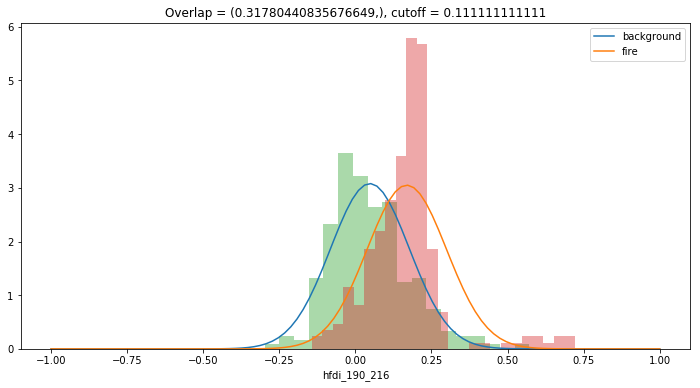

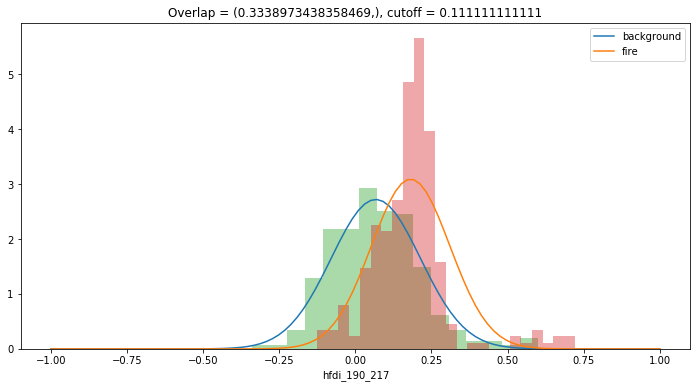

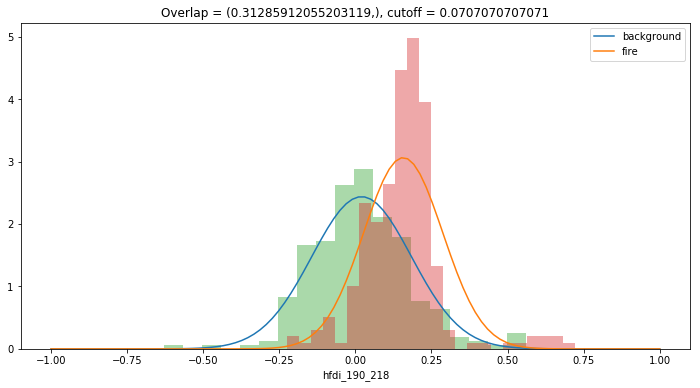

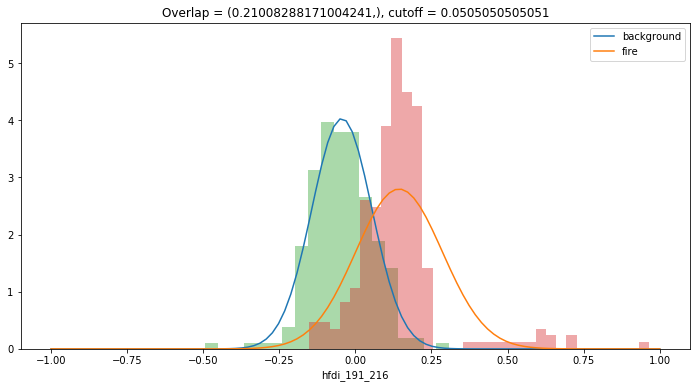

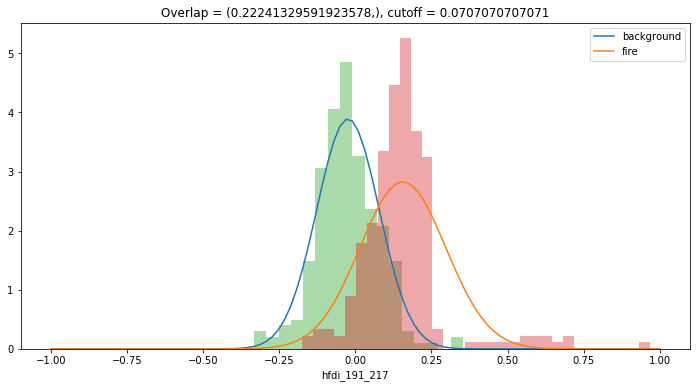

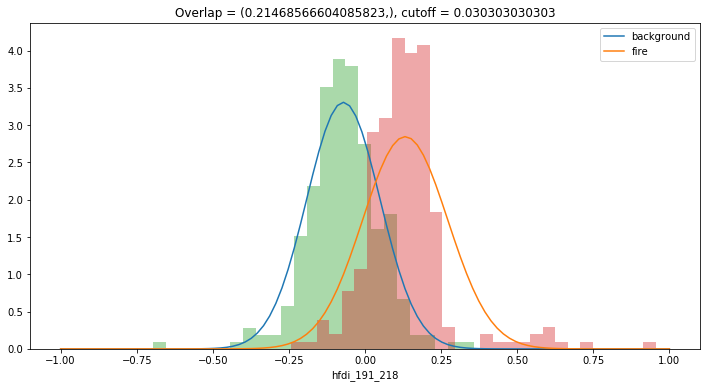

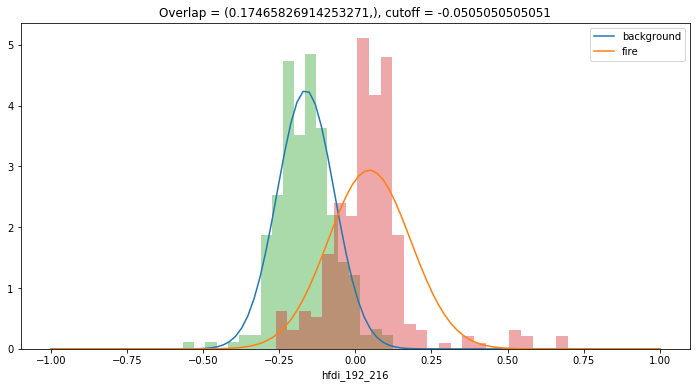

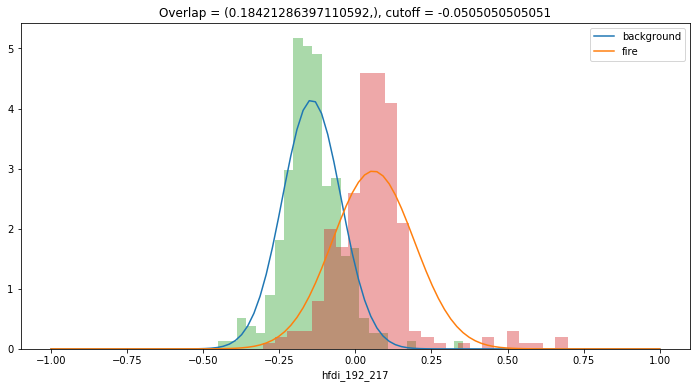

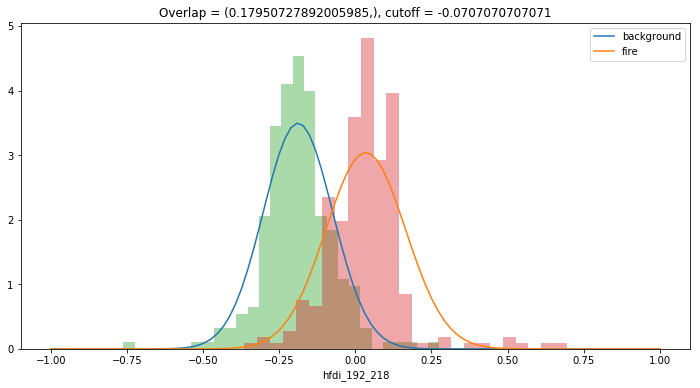

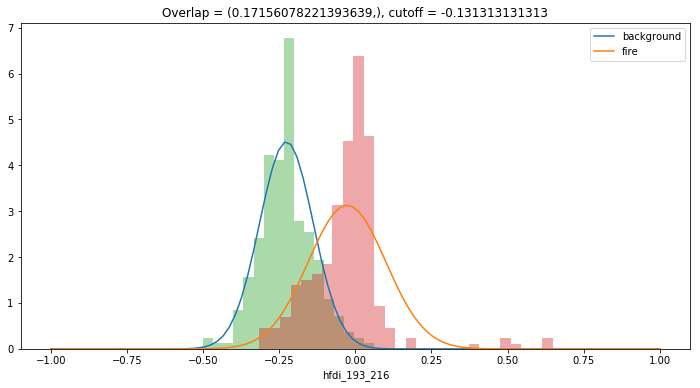

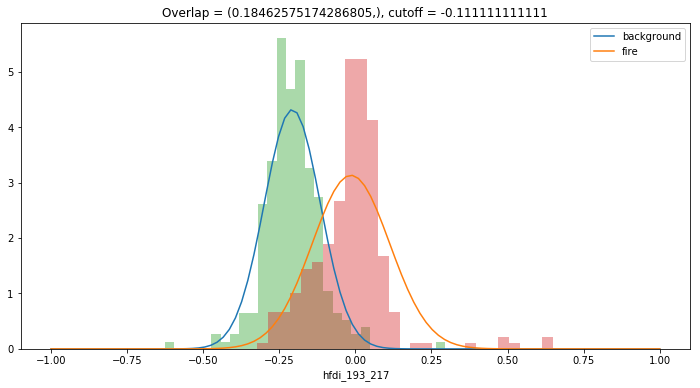

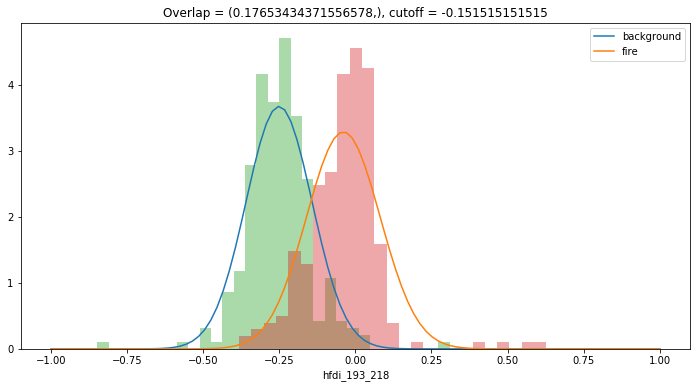

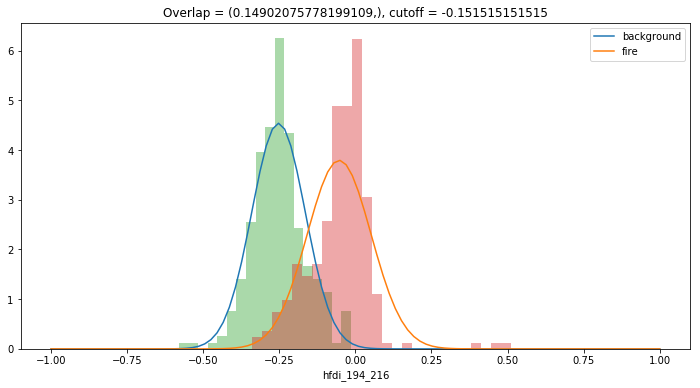

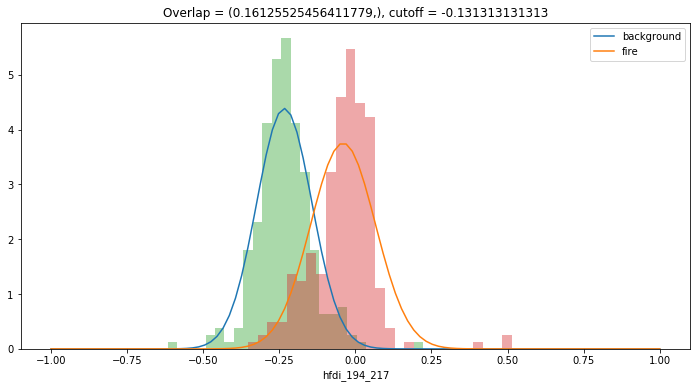

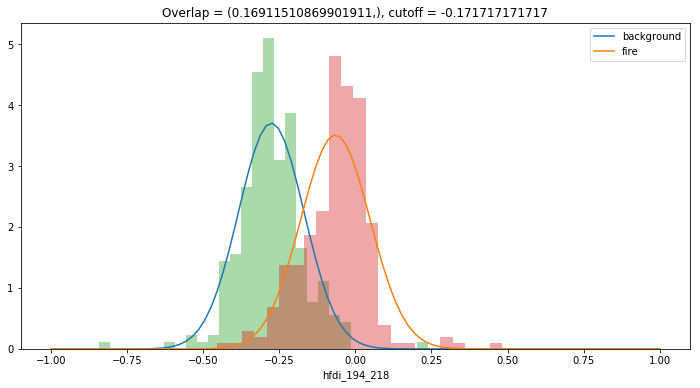

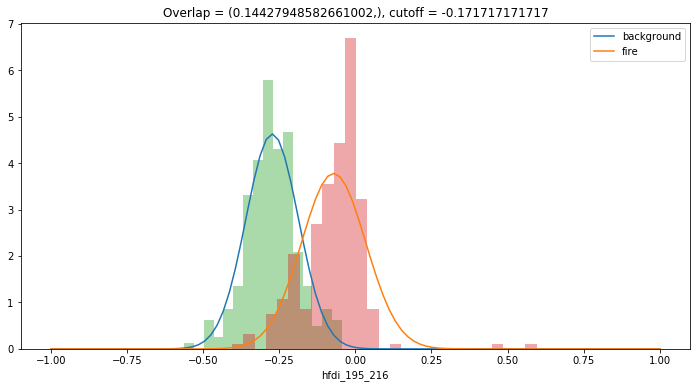

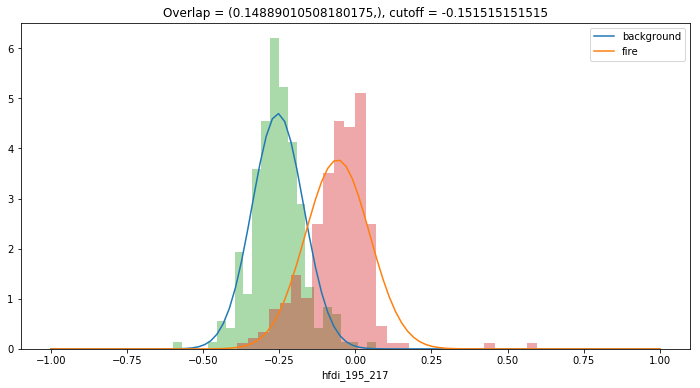

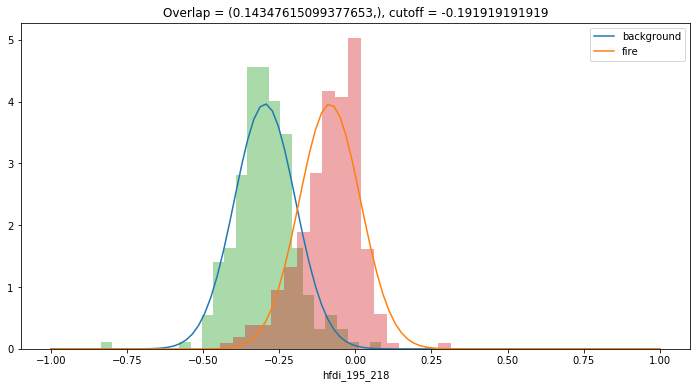

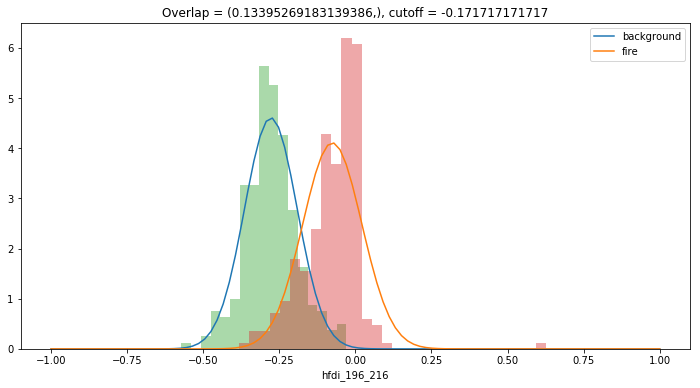

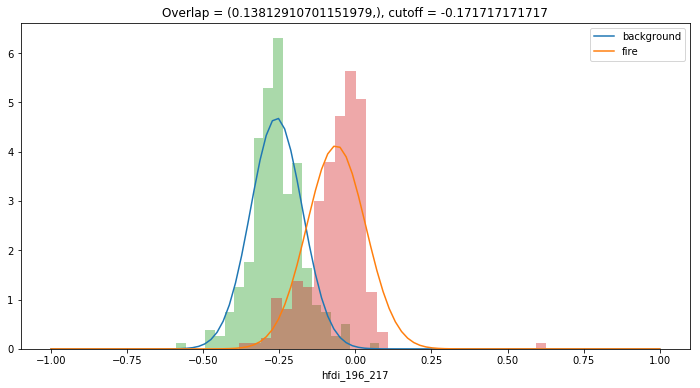

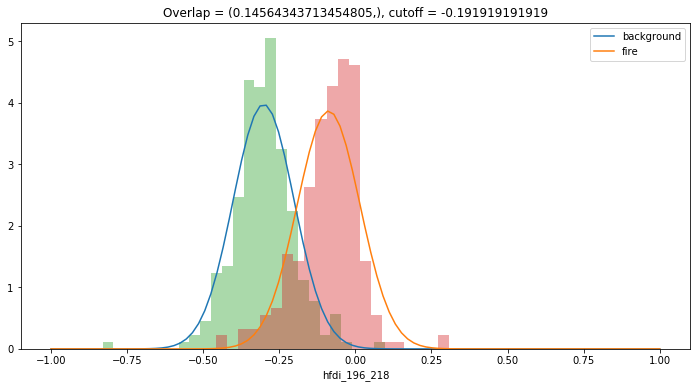

In [9]:
para = []
for (b1, b2) in itertools.product([190, 191, 192, 193, 194, 195, 196], [216, 217, 218]):

    bandlabel = 'hfdi_{}_{}'.format(b1, b2)
    curve_bg = stats.norm.pdf(np.linspace(-1, 1, N), mean_bg[bandlabel], std_bg[bandlabel])
    curve_fire = stats.norm.pdf(np.linspace(-1, 1, N), mean_fire[bandlabel], std_fire[bandlabel])
    mins = np.minimum(curve_bg, curve_fire)
    overlap = sum(mins)/N, 
    cutoff = np.argmax(mins)
    cutoff_x = np.linspace(-1, 1, N)[cutoff]
    para.append({
        'b1': b1,
        'b2': b2,
        'overlap': overlap,
        'cutoff': cutoff_x
    })
    
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(
        np.linspace(-1, 1, N), 
        curve_bg, label='background')
    ax.plot(
        np.linspace(-1, 1, N), 
        curve_fire, label='fire')
    sns.distplot(sampleDF[sampleDF.pixclass=='background'][bandlabel],
        kde=False, norm_hist=True, ax=ax)
    sns.distplot(sampleDF[sampleDF.pixclass=='fire'][bandlabel],
        kde=False, norm_hist=True, ax=ax)
    ax.legend()
    ax.set_title("Overlap = {}, cutoff = {}".format(overlap, cutoff_x))

In [10]:
parameters = pd.DataFrame.from_records(para)

In [11]:
parameters

,b1,b2,cutoff,overlap
0,190,216,0.111111,"(0.317804408357,)"
1,190,217,0.111111,"(0.333897343836,)"
2,190,218,0.070707,"(0.312859120552,)"
3,191,216,0.050505,"(0.21008288171,)"
4,191,217,0.070707,"(0.222413295919,)"
5,191,218,0.030303,"(0.214685666041,)"
6,192,216,-0.050505,"(0.174658269143,)"
7,192,217,-0.050505,"(0.184212863971,)"
8,192,218,-0.070707,"(0.17950727892,)"
9,193,216,-0.131313,"(0.171560782214,)"


In [12]:
parameters['overlap'] = parameters.apply(
    lambda row: row['overlap'][0], axis=1
)

In [13]:
parameters.sort_values('overlap')

,b1,b2,cutoff,overlap
18,196,216,-0.171717,0.133953
19,196,217,-0.171717,0.138129
17,195,218,-0.191919,0.143476
15,195,216,-0.171717,0.144279
20,196,218,-0.191919,0.145643
16,195,217,-0.151515,0.148890
12,194,216,-0.151515,0.149021
13,194,217,-0.131313,0.161255
14,194,218,-0.171717,0.169115
9,193,216,-0.131313,0.171561


In [14]:
(sampleDF[sampleDF['pixclass']=='fire']['hfdi_192_217'] > -0.050505
    ).astype('int').sum() / len(sampleDF[sampleDF['pixclass']=='fire'])

0.82799999999999996

In [15]:
parameters.iloc[14]

def tpr(row):
    colname = 'hfdi_{}_{}'.format(int(row['b1']), int(row['b2']))
    return (sampleDF[sampleDF['pixclass']=='fire'][colname] > row['cutoff']
    ).astype('int').sum() / len(sampleDF[sampleDF['pixclass']=='fire'])

def tnr(row):
    colname = 'hfdi_{}_{}'.format(int(row['b1']), int(row['b2']))
    return (sampleDF[sampleDF['pixclass']=='background'][colname] < row['cutoff']
    ).astype('int').sum() / len(sampleDF[sampleDF['pixclass']=='background'])

def ppv(row):
    colname = 'hfdi_{}_{}'.format(int(row['b1']), int(row['b2']))
    return (sampleDF[sampleDF['pixclass']=='fire'][colname] > row['cutoff']
    ).astype('int').sum() / (sampleDF[colname] > row['cutoff']).astype('int').sum()

def f1score(row):
    return 2 * tpr(row) * ppv(row) / (tpr(row) + ppv(row))

In [16]:
parameters['truedetectionrate'] = parameters.apply(tpr, axis=1)
parameters['pospredvalue'] = parameters.apply(ppv, axis=1)
parameters['f1score'] = parameters.apply(f1score, axis=1)

In [19]:
parameters = parameters.sort_values(by='f1score', ascending=False).round(3)

In [21]:
parameters.to_csv(
    os.path.join(outdir, "allfires_HFDI_eval.dat"), sep='\t', index=False)

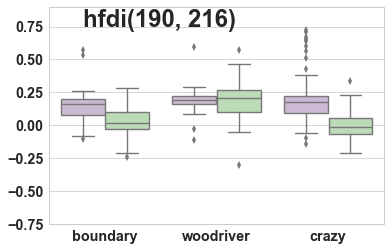

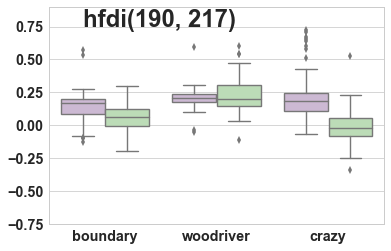

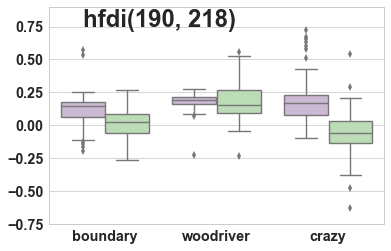

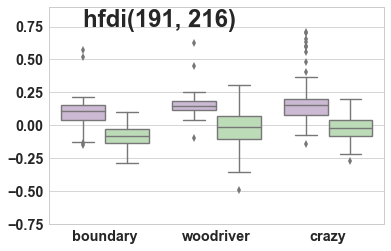

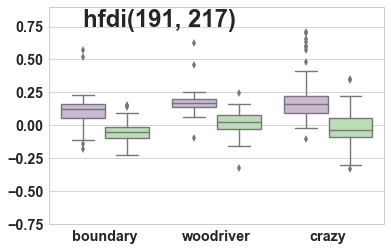

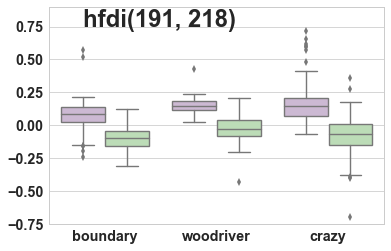

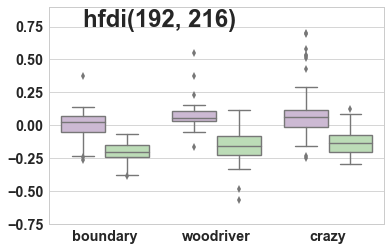

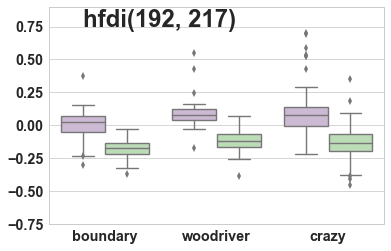

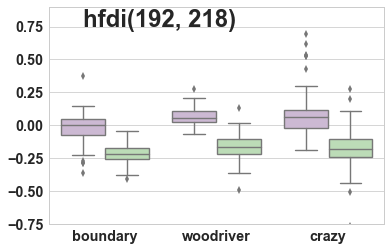

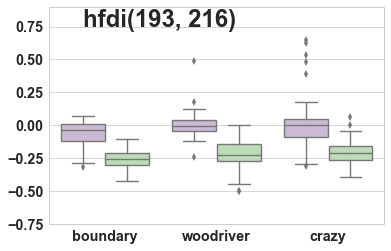

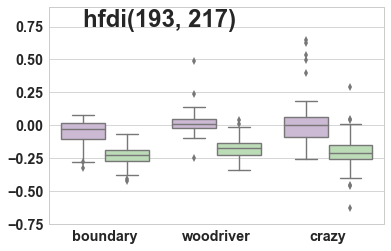

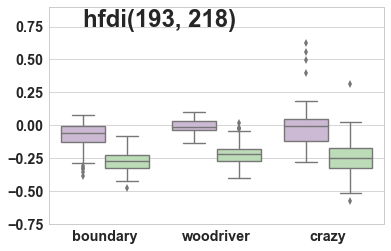

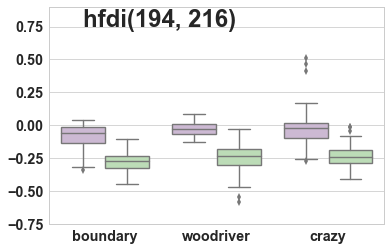

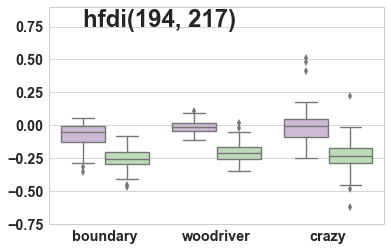

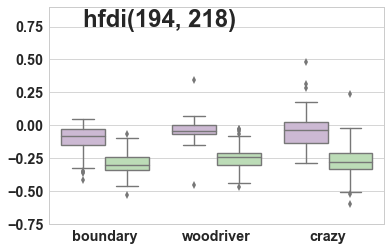

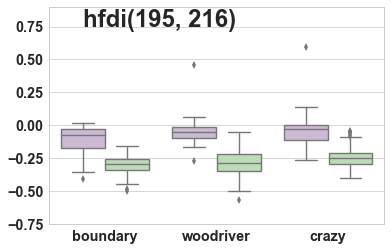

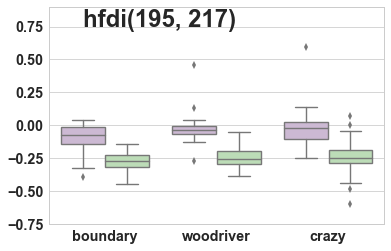

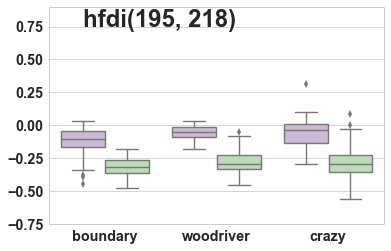

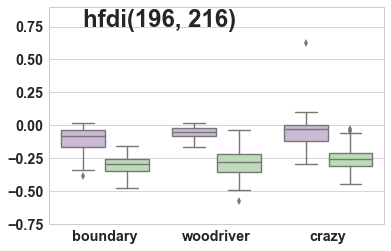

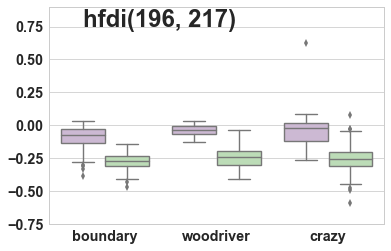

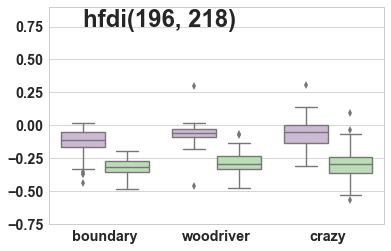

In [100]:
for low, high in itertools.product([190, 191, 192, 193, 194, 195, 196], [216, 217, 218]):
    ax = sns.boxplot(x="firename", y="hfdi_{}_{}".format(low, high), hue="pixclass", data=sampleDF, palette="PRGn")
    ax.legend_.remove()
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim([-0.75, .9])
    ax.text(-.2, .75, 'hfdi({}, {})'.format(low, high), fontsize=24)
    plt.show()

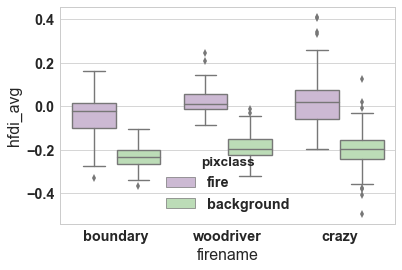

In [51]:
sns.boxplot(x="firename", y="hfdi_avg", hue="pixclass", data=sampleDF, palette="PRGn")

In [52]:
sns.set_context('paper', font_scale=1.8)
sns.set_style('whitegrid')

In [114]:
sampleDF.columnsumns

Index([u'firename', u'ii', u'jj', u'pixclass', u'rad_band42', u'rad_band43',
       u'rad_band183', u'rad_band185', u'rad_band188', u'rad_band190',
       u'rad_band191', u'rad_band192', u'rad_band193', u'rad_band194',
       u'rad_band195', u'rad_band196', u'rad_band216', u'rad_band217',
       u'rad_band218', u'co2cibr', u'kemiss', u'kemiss_akbd', u'hfdi_190_216',
       u'hfdi_190_217', u'hfdi_190_218', u'hfdi_191_216', u'hfdi_191_217',
       u'hfdi_191_218', u'hfdi_192_216', u'hfdi_192_217', u'hfdi_192_218',
       u'hfdi_193_216', u'hfdi_193_217', u'hfdi_193_218', u'hfdi_194_216',
       u'hfdi_194_217', u'hfdi_194_218', u'hfdi_195_216', u'hfdi_195_217',
       u'hfdi_195_218', u'hfdi_196_216', u'hfdi_196_217', u'hfdi_196_218',
       u'hfdi_avg'],
      dtype='object')

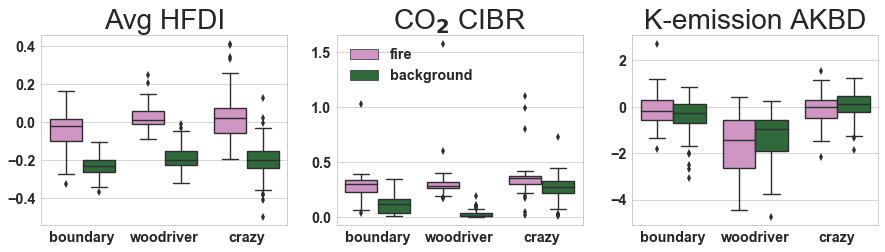

In [117]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3.5))
sns.boxplot(x="firename", 
            y="hfdi_avg", 
            hue="pixclass", data=sampleDF,  palette="cubehelix_r", saturation=.85,
            ax=ax1)
ax1.set_title("Avg HFDI", fontsize=28)
sns.boxplot(x="firename", y="co2cibr", hue="pixclass", data=sampleDF,  palette="cubehelix_r", saturation=.85,
           ax=ax2)
ax2.set_title("CO${}_2$ CIBR", fontsize=28)
sns.boxplot(x="firename", y="kemiss_akbd", hue="pixclass", data=sampleDF,  palette="cubehelix_r", saturation=.85,
           ax=ax3)
ax3.set_title("K-emission AKBD", fontsize=28)
for ax in [ax1, ax2, ax3]:
    ax.legend_.remove()
    ax.set_ylabel("")
    ax.set_xlabel("")
#    ax.set_ylim([-0.75, .81])
ax2.legend(loc=2)
#ax2.set_yticklabels([])
#ax3.set_yticklabels([])
#fig.subplots_adjust(hspace=0.1, wspace=0.25)

In [119]:
outfn = 'Fig06_LR.eps'
fig.savefig(os.path.join(outdir, outfn), dpi=150, bb_inches='tight')

In [120]:
outfn = 'Fig06_LR.png'
fig.savefig(os.path.join(outdir, outfn), dpi=150, bb_inches='tight')

### Random forest classifications

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [136]:
classmapping = {'fire': 1, 'background': 0 }
testdata = sampleDF.as_matrix(columns=hfdicols+['co2cibr'])

In [140]:
datalabels = sampleDF.pixclass.map(classmapping).values

In [148]:
clf = RandomForestClassifier(max_depth=4, n_estimators=100, max_features=1, random_state=100)
clf = clf.fit(testdata, datalabels)


In [149]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    testdata, datalabels, test_size=0.4, random_state=0)

In [191]:
scores = []

In [192]:
for _ in itertools.repeat(None, 20):

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        testdata, datalabels, test_size=0.4)
    clf = RandomForestClassifier(max_depth=4, n_estimators=100, max_features=1).fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

In [175]:
testdata2 = sampleDF.as_matrix(columns=['hfdi_avg'])

In [195]:
np.array(scores).mean(), np.array(scores).std()

(0.89025000000000021, 0.014956186011146037)

In [196]:
scores=[]

In [197]:
for _ in itertools.repeat(None, 20):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        testdata2, datalabels, test_size=0.4)
    clf = RandomForestClassifier(max_depth=4, n_estimators=100, max_features=1).fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

In [198]:
np.array(scores).mean(), np.array(scores).std()

(0.86900000000000011, 0.016926310879810769)

## Plot those

In [121]:
from pygaarst import irutils as ir

In [122]:
bands = {}
plotbandnums1 = [191, 192, 193, 194, 195, 196, 216, 217, 218]
plotbandnums2 = [183, 185, 188]
plotbandnums3 = [42, 43]
plotbandnames = ['band{}'.format(n) for n in plotbandnums1+plotbandnums2+plotbandnums3]
cibrmap = {}
avg_hfdimap = {}
k_akbdmap = {}

In [123]:
def co2cibr_single(h1, h2, low):
    return low / (0.6667*h1 + 0.3333*h2)
def k_akbd(b1, b2):
    return b1 - b2

In [129]:
for fnm in ['crazy', 'boundary']:
    bands[fnm] = {}
    for num, name in zip(plotbandnums1+plotbandnums2+plotbandnums3, plotbandnames):
        bands[fnm][num] = hypsc[fnm].__getattr__(name).radiance

In [130]:
for fnm in ['crazy', 'boundary']:
    cibrmap[fnm] = co2cibr_single(bands[fnm][183], bands[fnm][188], bands[fnm][185])
    cibrmap[fnm] = np.nan_to_num(cibrmap[fnm])
    k_akbdmap[fnm] = k_akbd(bands[fnm][42], bands[fnm][43])
    k_akbdmap[fnm] = np.nan_to_num(k_akbdmap[fnm])
    helper = np.zeros(bands[fnm][191].shape)
    for ii, jj in itertools.product([191, 192, 193, 194, 195, 196], [216, 217, 218]):
        helper = helper + np.nan_to_num(ir.normdiff(bands[fnm][jj], bands[fnm][ii]))
    avg_hfdimap[fnm] = helper / 18.0




/Users/cwaigl/miniconda3/envs/snakes/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  







































In [131]:
my_cmap = sns.light_palette("Navy", as_cmap=True)
my_cmap = sns.diverging_palette(250,10, l=80, n=7, center="dark", as_cmap=True)
my_cmap = sns.cubehelix_palette(8, start=1, rot=0, dark=0, light=.95, as_cmap=True)

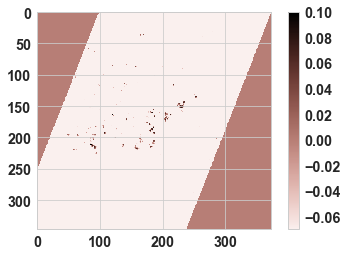

In [132]:
boundaryplot = plt.imshow(avg_hfdimap['boundary'], interpolation='none', cmap=my_cmap, vmin=-0.07, vmax=0.1)
plt.colorbar(boundaryplot)

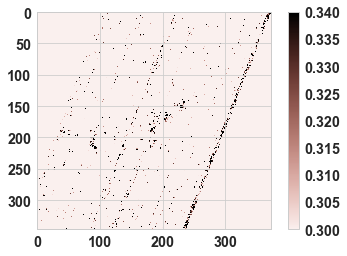

In [133]:
boundaryplot = plt.imshow(cibrmap['boundary'], interpolation='none', cmap=my_cmap, vmin=.30, vmax=0.34)
plt.colorbar(boundaryplot)

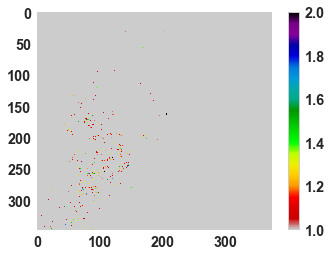

In [134]:
boundaryplot = plt.imshow(k_akbdmap['boundary'], interpolation='none', cmap='nipy_spectral_r', vmin=1, vmax=2)
plt.colorbar(boundaryplot)

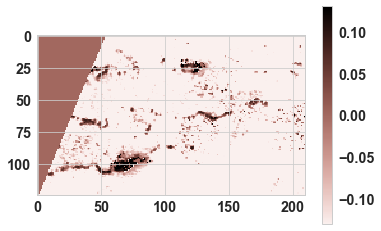

In [87]:
crazyplot = plt.imshow(avg_hfdimap['crazy'], interpolation='none', cmap=my_cmap, vmin=-0.13, vmax=0.13)
plt.colorbar(crazyplot)

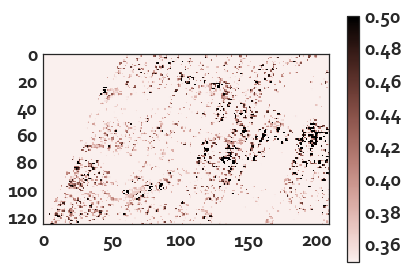

In [351]:
crazyplot = plt.imshow(cibrmap['crazy'], interpolation='none', cmap=my_cmap, vmin=.35, vmax=0.5)
plt.colorbar(crazyplot)

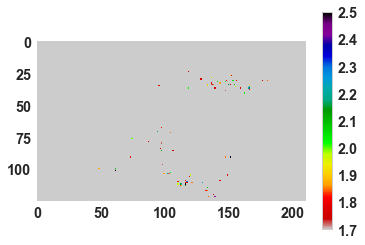

In [137]:
crazyplot = plt.imshow(k_akbdmap['crazy'], interpolation='none', cmap='nipy_spectral_r', vmin=1.7, vmax=2.5)
plt.colorbar(crazyplot)

([array([   0.,    0.,    0.,    0.,    1.,   40.,  305.,    1.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    1.,   31.,  313.,    2.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    2.,   34.,  311.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   41.,  304.,    2.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   48.,  299.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   43.,  301.,    3.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   40.,  304.,    3.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   40.,  305.,    2.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   42.,  304.,    1.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    1.,   41.,  302.,    3.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   44.,  300.,    3.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,   47.,  294.,    6.,    0.,    0.]),
  array([   0.,    0.,    0.

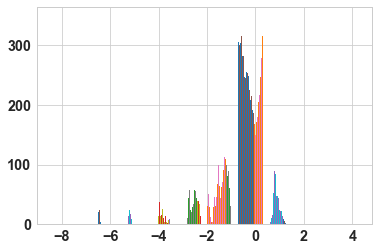

In [138]:
plt.hist(k_akbdmap['boundary'])

In [139]:
np.max(k_akbdmap['boundary'])

4.2999992

In [136]:
import matplotlib.gridspec as gridspec


In [166]:
sns.set_context('paper', font_scale=2.5)
font = {'family' : 'Corbel',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)

Text(236.5,242,u'1 km')

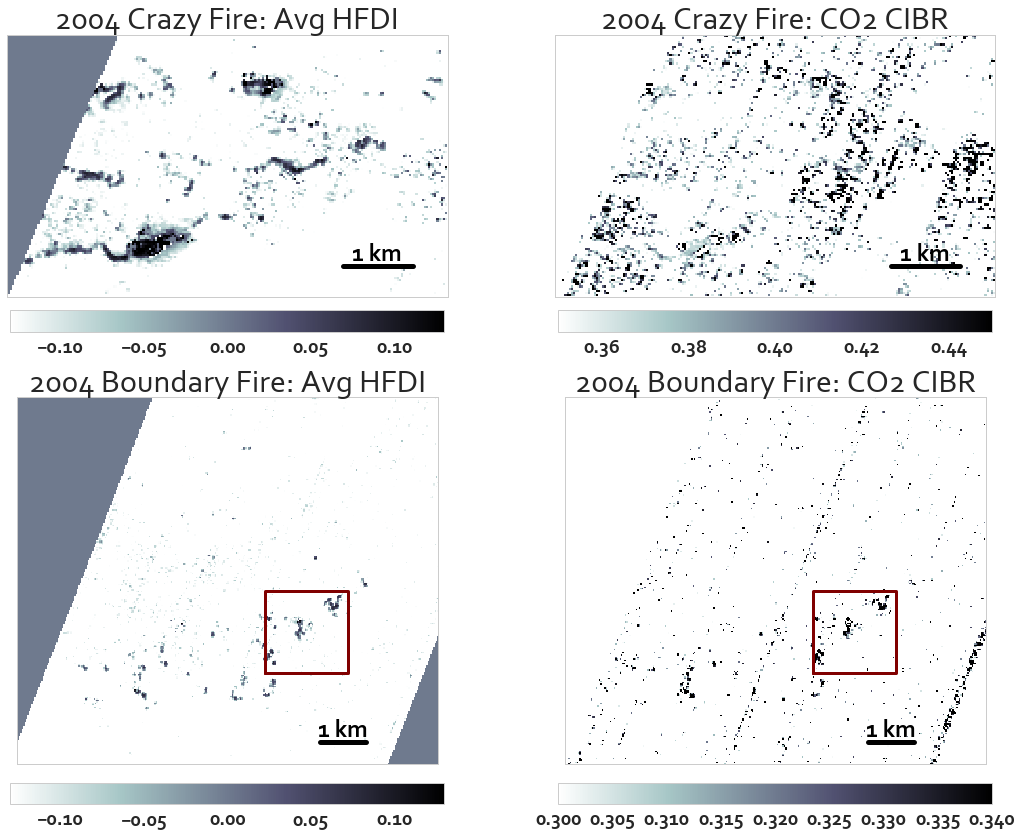

In [171]:
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 1],
                       height_ratios=[20, 28],
                       hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_aspect('equal')
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
for ax in [ax3, ax4]:
    ax.set_ylim([266, 0])
    ax.set_xlim([0, 305])
for ax in [ax1, ax2]:
    ax.set_ylim([125, 0])
    ax.set_xlim([0, 210])

ax1.set_title(u"2004 Crazy Fire: Avg HFDI", fontsize=32)
ax2.set_title(u"2004 Crazy Fire: CO2 CIBR", fontsize=32)
ax3.set_title(u"2004 Boundary Fire: Avg HFDI", fontsize=32)
ax4.set_title(u"2004 Boundary Fire: CO2 CIBR", fontsize=32)
hfdic = ax1.imshow(avg_hfdimap['crazy'], interpolation='none', cmap='bone_r', vmin=-0.13, vmax=0.13)
plt.colorbar(hfdic, ax=ax1, shrink=0.95, pad=0.04, orientation='horizontal')
cibrc = ax2.imshow(cibrmap['crazy'], interpolation='none', cmap='bone_r', vmin=.35, vmax=0.45)
plt.colorbar(cibrc, ax=ax2, shrink=0.95, pad=0.04, orientation='horizontal')
hfdib = ax3.imshow(avg_hfdimap['boundary'], interpolation='none', cmap='bone_r', vmin=-0.13, vmax=0.13)
plt.colorbar(hfdib, ax=ax3, shrink=0.95, pad=0.04, orientation='horizontal')
cibrb = ax4.imshow(cibrmap['boundary'], interpolation='none', cmap='bone_r', vmin=.30, vmax=0.34)
plt.colorbar(cibrb, ax=ax4, shrink=0.95, pad=0.04, orientation='horizontal')

# zoom frame
for ax in [ax3, ax4]:
    ax.plot([180, 240, 240, 180, 180], [200, 200, 140, 140, 200], color='maroon', lw=3)


# scale bars
ax1.plot([160, 193.33], [110, 110], color='k', lw=5)
ax1.text(176.5, 105, 
         '1 km', 
          ha="center", va="center", 
          color='k')
ax2.plot([160, 193.33], [110, 110], color='k', lw=5)
ax2.text(176.5, 105, 
         '1 km', 
          ha="center", va="center", 
          color='black')
ax3.plot([220, 253.33], [250, 250], color='k', lw=5)
ax3.text(236.5, 242, 
         '1 km', 
          ha="center", va="center", 
          color='k')
ax4.plot([220, 253.33], [250, 250], color='k', lw=5)
ax4.text(236.5, 242, 
         '1 km', 
          ha="center", va="center", 
          color='black')

#fig.subplots_adjust(left=.025, right=.99, wspace=0, hspace=0.2)

In [172]:
outfn = 'Fig06a_LR.eps'
fig.savefig(os.path.join(outdir, outfn), dpi=150, bb_inches='tight')

In [173]:
outfn = 'Fig06a.png'
fig.savefig(os.path.join(outdir, outfn), dpi=350, bb_inches='tight')

#### Comparison with previous classification

In [144]:
classifications = {}

In [145]:
for firename in  ['boundary', 'crazy']:
    classifications[firename] = raster.GeoTIFF(os.path.join(
        basedir, configs.FIREPARAM[firename]['filedir'], '{}_random_forest_extraction.tif'.format(firename))).data


In [146]:
cibrmask = np.ma.masked_where(np.logical_or((cibrmap['crazy'] <= .35),(classifications['crazy'] == 4)), 
                             cibrmap['crazy'])

In [147]:
colors = ['yellow', 'sienna', 'limegreen', 'aqua', 'white']
cmap = mpl.colors.ListedColormap(colors)

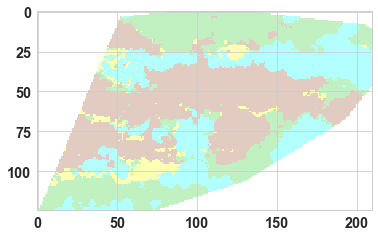

In [148]:
plt.imshow(classifications['crazy'], cmap=cmap, interpolation='none', alpha=.3)

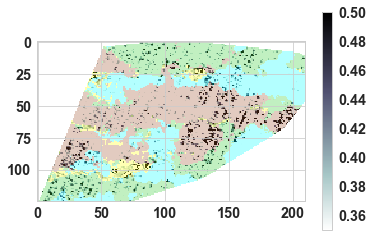

In [149]:
fig, ax = plt.subplots(1, 1)
crazyplot = plt.imshow(cibrmask, interpolation='none', cmap='bone_r', vmin=.35, vmax=0.5)
ax.imshow(classifications['crazy'], cmap=cmap, interpolation='none', alpha=.3)
plt.colorbar(crazyplot)

In [150]:
cibrmask = np.ma.masked_where(np.logical_or((cibrmap['boundary'] <= .3),(classifications['boundary'] == 4)), 
                             cibrmap['boundary'])

In [151]:
k_akbdmask = np.ma.masked_where(np.logical_or((k_akbdmap['boundary'] <= 1.2),(classifications['boundary'] == 4)), 
                             k_akbdmap['boundary'])

In [152]:
hfdidmask = np.ma.masked_where(np.logical_or((avg_hfdimap['boundary'] <= -.12),(classifications['boundary'] == 4)), 
                             avg_hfdimap['boundary'])

Text(0.5,1,u'Zoom K-AKBD')

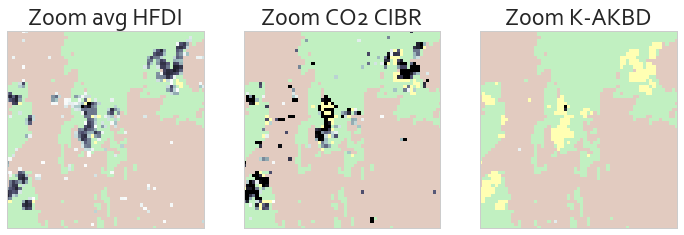

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
for ax in (ax1, ax2, ax3):
    ax.set_ylim([200, 140])
    ax.set_xlim([180, 240])
    ax.set_aspect('equal')
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(classifications['boundary'], cmap=cmap, interpolation='none', alpha=.3)
boundaryplotk = ax3.imshow(k_akbdmask, interpolation='none', cmap='bone_r', vmin=1.2, vmax=3)
boundaryplotc = ax2.imshow(cibrmask, interpolation='none', cmap='bone_r', vmin=.3, vmax=0.35)
boundaryploth = ax1.imshow(hfdidmask, interpolation='none', cmap='bone_r', vmin=-.12, vmax=.12)
ax1.set_title("Zoom avg HFDI")
ax2.set_title("Zoom CO2 CIBR")
ax3.set_title("Zoom K-AKBD")


#plt.colorbar(boundaryplotc, ax=ax1, orientation='horizontal', pad=.05)
#plt.colorbar(boundaryplotk, ax=ax2, orientation='horizontal', pad=.05)
#plt.colorbar(boundaryploth, ax=ax3, pad=.05)


In [176]:
outfn = 'Fig06b_LR.png'
fig.savefig(os.path.join(outdir, outfn), dpi=150, bb_inches='tight')